In [1]:
cd "C:\srec\dataset_for_sih"
os.getcwd()

c:\srec\dataset_for_sih


'c:\\srec\\dataset_for_sih'

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [3]:

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("C:/srec/dataset_for_sih/train",
                                          target_size=(150,150),
                                          batch_size = 5,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("C:/srec/dataset_for_sih/test",
                                          target_size=(150,150),
                                          batch_size =5,
                                          class_mode = 'binary')

Found 30 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


In [39]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for photo or 1 for sign 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
#steps_per_epoch = train_imagesize/batch_size

model.fit_generator(train_dataset,
         steps_per_epoch = 3, 
         epochs = 10,
         validation_data = test_dataset
       
         )

Epoch 1/10


C:\Users\GE-INA924TKND\AppData\Local\Temp\ipykernel_8992\3733800372.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_dataset,


3/3 [==============================] - 1s 187ms/step - loss: 1.2532 - accuracy: 0.5333 - val_loss: 0.6942 - val_accuracy: 0.4615
Epoch 2/10
3/3 [==============================] - 0s 129ms/step - loss: 0.6969 - accuracy: 0.6000 - val_loss: 0.7150 - val_accuracy: 0.4615
Epoch 3/10
3/3 [==============================] - 0s 130ms/step - loss: 0.7113 - accuracy: 0.6000 - val_loss: 0.7126 - val_accuracy: 0.4615
Epoch 4/10
3/3 [==============================] - 0s 129ms/step - loss: 0.6785 - accuracy: 0.5333 - val_loss: 0.6819 - val_accuracy: 0.4615
Epoch 5/10
3/3 [==============================] - 0s 132ms/step - loss: 0.6605 - accuracy: 0.9333 - val_loss: 0.6565 - val_accuracy: 0.7692
Epoch 6/10
3/3 [==============================] - 0s 132ms/step - loss: 0.6474 - accuracy: 0.7333 - val_loss: 0.6525 - val_accuracy: 0.4615
Epoch 7/10
3/3 [==============================] - 0s 129ms/step - loss: 0.6158 - accuracy: 0.6667 - val_loss: 0.7088 - val_accuracy: 0.4615
Epoch 8/10
3/3 [===============

In [15]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:   
        plt.xlabel("sign",fontsize=30)    
    elif val == 0:
    
        plt.xlabel("photo",fontsize=30)

[[0.]]


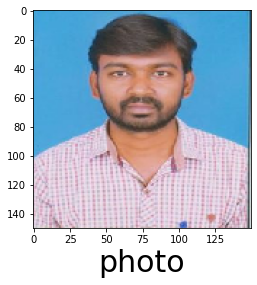

In [16]:
predictImage("pp.jpg")


[[1.]]


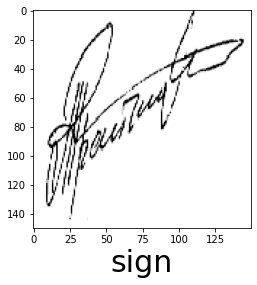

In [17]:
predictImage("test1.png")

In [42]:
import io
import os
import time
from typing import Tuple

import cv2
import numpy as np
from PIL import Image


def generate_test_image(ratio: Tuple[int, int], file_size: int) -> Image:
    """
        Generate a test image with fixed width height ratio and an approximate size.

        :param ratio: (Tuple[int, int]) screen ratio for the image
        :param file_size: (int) Approximate size of the image, note that this may be off due to image compression.
    """
    height, width = ratio  # Numpy reverse values
    scale = np.int(np.sqrt(file_size // (width * height)))
    img = np.random.randint(0, 255, (width * scale, height * scale, 3), dtype=np.uint8)
    return img


def _change_image_memory(path, file_size: int = 2 ** 20):
    """
        Tries to match the image memory to a specific file size.

        :param path: (str) Path to the image
        :param file_size: (int) Size of the file in bytes
        :return: (np.ndarray) rescaled version of the image
    """
    image = cv2.imread(path)
    height, width = image.shape[:2]

    original_memory = os.stat(path).st_size
    original_bytes_per_pixel = original_memory / np.product(image.shape[:2])

    # perform resizing calculation
    new_bytes_per_pixel = original_bytes_per_pixel * (file_size / original_memory)
    new_bytes_ratio = np.sqrt(new_bytes_per_pixel / original_bytes_per_pixel)
    new_width, new_height = int(new_bytes_ratio * width), int(new_bytes_ratio * height)

    new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR_EXACT)
    return new_image


def _get_size_of_image(image):
    # Encode into memory and get size
    buffer = io.BytesIO()
    image = Image.fromarray(image)
    image.save(buffer, format="JPEG")
    size = buffer.getbuffer().nbytes
    return size


def limit_image_memory(path, max_file_size: int, delta: float = 0.05, step_limit=10):
    """
        Reduces an image to the required max file size.

        :param path: (str) Path to the original (unchanged) image.
        :param max_file_size: (int) maximum size of the image
        :param delta: (float) maximum allowed variation from the max file size.
            This is a value between 0 and 1, relatively to the max file size.
        :return: an image path to the limited image.
    """
    start_time = time.perf_counter()
    max_file_size = max_file_size * (1 - delta)
    max_deviation_percentage = delta
    new_image = None

    current_memory = new_memory = os.stat(image_location).st_size
    ratio = 1
    steps = 0

    while abs(1 - max_file_size / new_memory) > max_deviation_percentage:
        new_image = _change_image_memory(path, file_size=max_file_size * ratio)
        new_memory = _get_size_of_image(new_image)
        ratio *= max_file_size / new_memory
        steps += 1

        # prevent endless looping
        if steps > step_limit:  break

    print(f"Stats:"
          f"\n\t- Original memory size: {current_memory / 2 ** 20:9.2f} MB"
          f"\n\t- New memory size     : {new_memory / 2 ** 20:9.2f} MB"
          f"\n\t- Number of steps {steps}"
          f"\n\t- Time taken: {time.perf_counter() - start_time:5.3f} seconds")

    if new_image is not None:
        cv2.imwrite(f"resize {path}", new_image)
        return f"resize {path}"
    return path



image_location = "passport.jpg"


path = limit_image_memory(image_location, max_file_size=190000, delta=0.01)

Stats:
	- Original memory size:      0.04 MB
	- New memory size     :      0.18 MB
	- Number of steps 6
	- Time taken: 0.103 seconds


In [43]:
image_location = "land.jpg"

path = limit_image_memory(image_location, max_file_size=190000, delta=0.01)

Stats:
	- Original memory size:      1.48 MB
	- New memory size     :      0.18 MB
	- Number of steps 3
	- Time taken: 0.429 seconds
